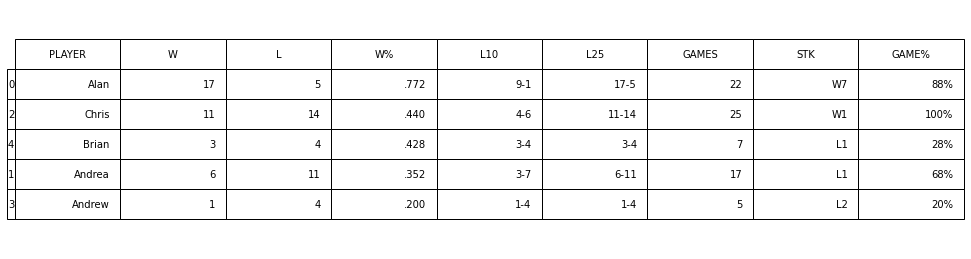

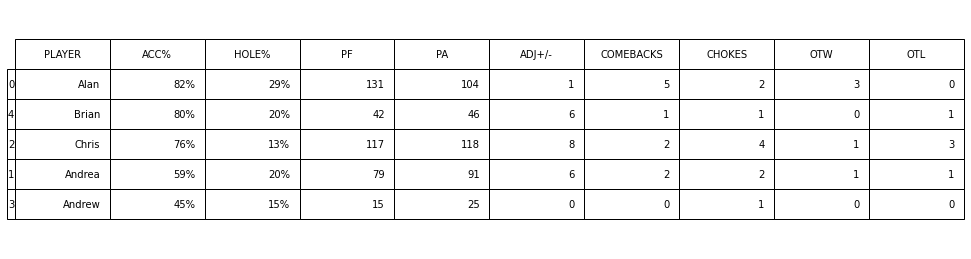

In [3]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

playerLookup = {}
games = []

short_name_map = {
    "Player": "PLAYER",
    "Wins": "W",
    "Losses": "L",
    "Win Pct": "W%",
    "Last 10": "L10",
    "Last 25": "L25",
    "Games": "GAMES",
    "Accuracy": "ACC%",
    "Make Pct": "HOLE%",
    "Points For": "PF",
    "Points Against": "PA",
    "Streak": "STK",
    "Net Points Adjusted": "ADJ+/-",
    "Comebacks": "COMEBACKS",
    "Chokes": "CHOKES",
    "OT Wins": "OTW",
    "OT Losses": "OTL",
    "Attendance": "GAME%",
}

def new_player(name):
    return {
        "Player": name,
        "Wins": 0,
        "Losses": 0,
        "Win Pct": 0,
        "Last 10": "0-0",
        "Last 25": "0-0",
        "Games": 0,
        "Accuracy": 0,
        "Make Pct": 0,
        "Points For": 0,
        "Points Against": 0,
        "Streak": "N/A",
        "Net Points Adjusted": 0,
        "Comebacks": 0,
        "Chokes": 0,
        "OT Wins": 0,
        "OT Losses": 0,
        "Attendance": 0,
    }

def get_or_create_player(data):
    name = data["Player"]
    if name not in playerLookup:
        playerLookup[name] = new_player(name)
    return playerLookup[name]

def add_win_loss(data, player):
    if data["W/L"] == "W":
        player["Wins"] += 1
    else:
        player["Losses"] += 1

def prep_accuracy(data, player):
    if "_acc_throws" not in player:
        player.update({"_acc_throws": []})
    for key, val in data.items():
        if "Bag" in key and val != "":
            player["_acc_throws"].append(int(val))
            
def prep_recent_win_loss(data, player):
    if "_rec_wl" not in player:
        player["_rec_wl"] = []
    player["_rec_wl"].append(data["W/L"])
    
def add_ot_win_loss(data, player):
    if data["Bag 5"] != "":
        if data["W/L"] == "W":
            player["OT Wins"] += 1
        else:
            player["OT Losses"] += 1

def add_points_adjusted(data, player):
    throws = []
    for key, val in data.items():
        if "Bag" in key and val != "":
            throws.append(int(val))
    final = int(data["Final"])
    total = sum(throws)
    if total != final:
        player["Net Points Adjusted"] += (final - total)
        
def add_comebacks_chokes(data, player, opponent_data):
    throws, opponent_throws = [], []
    for key, val in data.items():
        if "Bag" in key and val != "":
            throws.append(int(val))
    for key, val in opponent_data.items():
        if "Bag" in key and val != "":
            opponent_throws.append(int(val))
    was_winning, was_losing, a, b = 0, 0, 0, 0
    for i in range(len(throws)):
        a += throws[i]
        b += opponent_throws[i]
        if a < b:
            was_losing = True
        if a > b:
            was_winning = True
    if data["W/L"] == "W" and was_losing:
        player["Comebacks"] += 1
    if data["W/L"] == "L" and was_winning:
        player["Chokes"] += 1

def add_points_for_against(data, player, opponent_data):
    player["Points For"] += int(data["Final"])
    player["Points Against"] += int(opponent_data["Final"])

def add_accuracy():
    for player in playerLookup.values():
        hits, makes = 0, 0
        for throw in player["_acc_throws"]:
            if throw != 0:
                hits += 1
            if throw == 3:
                makes += 1
        player["Accuracy"] = str(int(hits / len(player["_acc_throws"]) * 100)) + "%"
        player["Make Pct"] = str(int(makes / len(player["_acc_throws"]) * 100)) + "%"

def add_win_pct():
    for player in playerLookup.values():
        player["Win Pct"] = "." + str(int(player["Wins"] / player["Games"] * 1000))
        
def add_attendance():
    max, players = 0, playerLookup.values()
    for player in players:
        if player["Games"] > max:
            max = player["Games"]
    for player in players:
        player["Attendance"] = str(int(player["Games"] / max * 100)) + "%"
        
def add_recent_win_loss():
    for player in playerLookup.values():
        win10, loss10, win25, loss25, streak = 0, 0, 0, 0, 0
        player["_rec_wl"]
        for result in player["_rec_wl"][-10:]:
            if result == "W":
                win10 += 1
            else:
                loss10 += 1
        for result in player["_rec_wl"][-25:]:
            if result == "W":
                win25 += 1
            else:
                loss25 += 1
        wl = None
        for result in reversed(player["_rec_wl"]):
            if wl == None:
                wl = result
            if result != wl:
                break
            streak += 1
            
        player["Last 10"] = f"{win10}-{loss10}"
        player["Last 25"] = f"{win25}-{loss25}"
        player["Streak"] = f"{wl}{streak}"

def add_facts(data, player, opponent_data):
    player["Games"] += 1
    add_win_loss(data, player)
    prep_accuracy(data, player)
    prep_recent_win_loss(data, player)
    add_ot_win_loss(data, player)
    add_points_adjusted(data, player)
    add_points_for_against(data, player, opponent_data)
    add_comebacks_chokes(data, player, opponent_data)
    
def add_calc_fields():
    add_win_pct()
    add_attendance()
    add_accuracy()
    add_recent_win_loss()

def load_games():
    with open("data.csv") as file:
        index, all = 0, [data for data in csv.DictReader(file)]
        while index < len(all):
            games.append(all[index:index+2])
            index += 2

def compute_stats():
    for game in games:
        for data in game:
            opponent_data = game[1] if game[0] == data else game[0]
            player = get_or_create_player(data)
            add_facts(data, player, opponent_data)
    add_calc_fields()
    
def show_table_common(df):
    fig, ax = plt.subplots()

    # Hide axes that comes with table
    fig.patch.set_visible(False)
    fig.tight_layout()
    ax.axis('off')

    table = ax.table(
        rowLabels=df.index, 
        colLabels=df.columns,
        cellText=df.values,
        loc='center')
    table.scale(2.5, 2.5)
    
def show_table_1():
    cols = ["Player", "Wins", "Losses", "Win Pct", "Streak", "Last 10", "Last 25", "Attendance", "Games"]
    filtered = [{ short_name_map[k]: v for k, v in player.items() if k in cols } for player in playerLookup.values()]
    df = pd.DataFrame(filtered)
    df = df.sort_values(by="W%", ascending=False)
    show_table_common(df)
    
def show_table_2():
    cols = [
        "Player", "Accuracy", "Make Pct", "Points For", "Points Against",
        "Net Points Adjusted", "OT Wins", "OT Losses", "Comebacks", "Chokes"]
    filtered = [{ short_name_map[k]: v for k, v in player.items() if k in cols } for player in playerLookup.values()]
    df = pd.DataFrame(filtered)
    df = df.sort_values(by="ACC%", ascending=False)
    show_table_common(df)

load_games()
compute_stats()
show_table_1()
show_table_2()

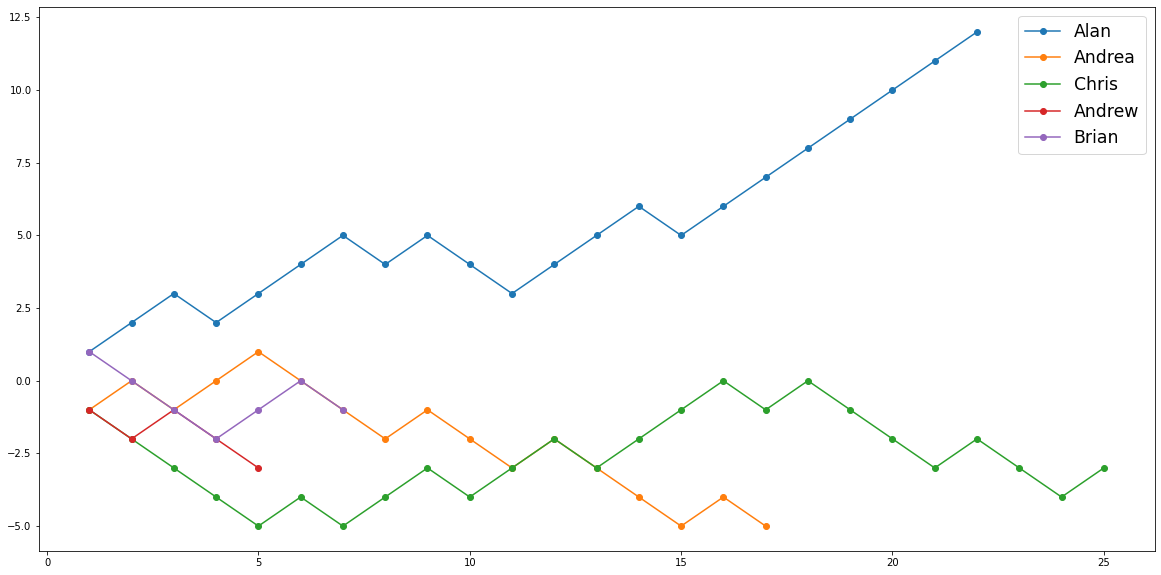

In [39]:
plt.figure(figsize=(20,10))
for k, v in playerLookup.items():
    y, x, xs, ys = 0, 0, [], []
    for n in [1 if res == "W" else -1 for res in v["_rec_wl"]]:
        y += n
        x += 1
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys, "o-",  label=k)
plt.legend(playerLookup.keys(), fontsize="xx-large")
plt.show()

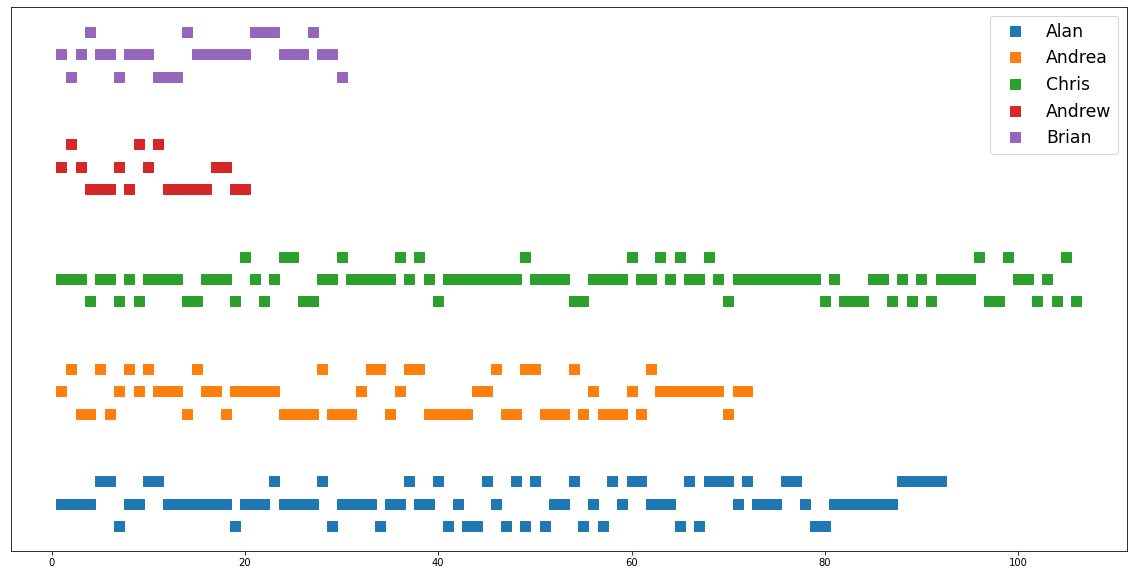

In [67]:
i = 0
plt.figure(figsize=(20,10))
plt.yticks([])
for k, v in playerLookup.items():
    y, x, xs, ys = 0, 0, [], []
    for n in v["_acc_throws"]:
        y = (1 if n == 3 else 0 if n == 1 else -1) + i
        x += 1
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys, "s", label=k, ms=10)
    i += 5
plt.legend(playerLookup.keys(), fontsize="xx-large")
plt.show()
